## Projet SVM 


In [126]:
# livrairies 
import kagglehub
import shutil
import os
import pandas as pd
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import numpy as np

from scipy.stats import zscore


In [83]:
#dossier src/ au path
src_path = Path.cwd().parent / "src"
sys.path.append(str(src_path))

# fonction propres si nous créons à mettre dans src/

In [84]:
palette = ["#C68E63", "#7F1D1D"]

# I. EDA : 

## 1) Exploration

In [85]:

#  copier le fichier
target_path = Path("..") / "data"

print("Dataset copié dans le dossier ./data du projet")

# chargement
csv_path = target_path / "smoking.csv"
df = pd.read_csv(csv_path)

print(" dataset chargé, dimensions :", df.shape)


Dataset copié dans le dossier ./data du projet
 dataset chargé, dimensions : (55692, 27)


In [86]:
df.head()       # Aperçu des premières lignes

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,...,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,...,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1
3,3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,...,14.7,1.0,1.0,19.0,26.0,18.0,Y,0,Y,0
4,4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,...,12.5,1.0,0.6,16.0,14.0,22.0,Y,0,N,0


In [87]:
df.shape        # (n_observations, n_variables)

(55692, 27)

Au total nos avons 55692, 27

## 2) Vérification des n/a et doublons

In [88]:
df.info() # nous permet de vérifier les types et na

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55692 non-null  int64  
 1   gender               55692 non-null  object 
 2   age                  55692 non-null  int64  
 3   height(cm)           55692 non-null  int64  
 4   weight(kg)           55692 non-null  int64  
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null 

**Corréction noms de variables**

In [89]:
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['ID', 'gender', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)',
       'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)',
       'systolic', 'relaxation', 'fasting_blood_sugar', 'Cholesterol',
       'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine_protein',
       'serum_creatinine', 'AST', 'ALT', 'Gtp', 'oral', 'dental_caries',
       'tartar', 'smoking'],
      dtype='object')

In [90]:
#  Valeurs manquantes
df.isna().sum().value_counts()


0    27
Name: count, dtype: int64

In [91]:
df.duplicated().sum()

np.int64(0)

In [92]:
# Suppression des doublons en ignorant la colonne 'ID'
df_no_duplicates = df.drop_duplicates(subset=[col for col in df.columns if col != 'ID'])

# Vérification : afficher le nombre de doublons supprimés
print(f"Nombre de doublons supprimés : {len(df) - len(df_no_duplicates)}")

Nombre de doublons supprimés : 11140


In [ ]:
# Remplacement du DataFrame initial par sa version sans doublons
df = df_no_duplicates

Notre jeu de données n'a pas de valeur manquants N/A, comme nous l'avions déjà vu avec info(), et nous avons détecté 11140 que nous avons donc supprimé 

## 3) Types

Nous allons séparer nous variables pour mieux les analyse en numeriques, catégoriques, etc et vérifier que les types sont correctes ou s'il faut les corriger 

In [93]:
def detect_variable_types(df):
    types = {
        "numerical": [],
        "categorical": [],
        "datetime": [],
        "boolean": [],
        "others": []
    }

    for col in df.columns:
        if pd.api.types.is_bool_dtype(df[col]):  # mettre ce test en premier
            types["boolean"].append(col)
        elif pd.api.types.is_numeric_dtype(df[col]):
            types["numerical"].append(col)
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            types["datetime"].append(col)
        elif pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
            types["categorical"].append(col)
        else:
            types["others"].append(col)

    return types


In [94]:
types = detect_variable_types(df)

print(" Variables numériques :", types["numerical"])
print(" Variables catégorielles :", types["categorical"])
print(" Variables date :", types["datetime"])
print(" Variables booléennes :", types["boolean"])


 Variables numériques : ['ID', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting_blood_sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine_protein', 'serum_creatinine', 'AST', 'ALT', 'Gtp', 'dental_caries', 'smoking']
 Variables catégorielles : ['gender', 'oral', 'tartar']
 Variables date : []
 Variables booléennes : []



**Correction manuelle des types :**

reclassement de certaines variables mal détectées (ex. 0/1 en booléen, codages en catégoriel)


In [95]:
#  Recatégorisation des variables pour l’analyse et la modélisation

# Supprimer les colonnes non informatives
df = df.drop(columns=["ID", "oral"])

# Recode de 'gender' en variable binaire : 1 = homme, 0 = femme, puis conversion en booléen
df["homme"] = df["gender"].map({"F": 0, "M": 1}).astype(bool)

# Recode des variables 'hearing' : 1 = normal, 2 = problème → 0/1, puis conversion en booléen
df["pb_hearing(left)"] = df["hearing(left)"].map({1: 0, 2: 1}).astype(bool)
df["pb_hearing(right)"] = df["hearing(right)"].map({1: 0, 2: 1}).astype(bool)

# Recode de 'tartar' : Y = 1, N = 0, puis conversion en booléen
df["tartar"] = df["tartar"].map({"Y": 1, "N": 0}).astype(bool)

# Conversion explicite des colonnes booléennes
df["dental_caries"] = df["dental_caries"].astype(bool)
df["smoking"] = df["smoking"].astype(bool)

# Supprimer les anciennes colonnes devenues redondantes
df = df.drop(columns=["gender", "hearing(left)", "hearing(right)"])

# Spécification de 'Urine_protein' comme variable catégorielle ordonnée
df["Urine_protein"] = pd.Categorical(df["Urine_protein"],
                                     categories=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
                                     ordered=True)

# Mise à jour des types pour structurer l’analyse
types = {
    "numerical": df.select_dtypes(include=["int64", "float64"]).columns.tolist(),
    "categorical": df.select_dtypes(include=["object", "category"]).columns.tolist(),
    "boolean": df.select_dtypes(include=["bool"]).columns.tolist()
}


## 4) Analyse statistique 

### 4.1) Variables numériques: 

In [101]:
numerical_cols = types["numerical"]

# Statistiques descriptives
df[numerical_cols].describe()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting_blood_sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum_creatinine,AST,ALT,Gtp
count,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000,55692.000000
mean,44.182917,164.649321,65.864936,82.046418,1.012623,1.007443,121.494218,76.004830,99.312325,196.901422,126.665697,57.290347,114.964501,14.622592,0.885738,26.182935,27.036037,39.952201
std,12.071418,9.194597,12.820306,9.274223,0.486873,0.485964,13.675989,9.679278,20.795591,36.297940,71.639817,14.738963,40.926476,1.564498,0.221524,19.355460,30.947853,50.290539
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,71.000000,40.000000,46.000000,55.000000,8.000000,4.000000,1.000000,4.900000,0.100000,6.000000,1.000000,1.000000
25%,40.000000,160.000000,55.000000,76.000000,0.800000,0.800000,112.000000,70.000000,89.000000,172.000000,74.000000,47.000000,92.000000,13.600000,0.800000,19.000000,15.000000,17.000000
50%,40.000000,165.000000,65.000000,82.000000,1.000000,1.000000,120.000000,76.000000,96.000000,195.000000,108.000000,55.000000,113.000000,14.800000,0.900000,23.000000,21.000000,25.000000
75%,55.000000,170.000000,75.000000,88.000000,1.200000,1.200000,130.000000,82.000000,104.000000,220.000000,160.000000,66.000000,136.000000,15.800000,1.000000,28.000000,31.000000,43.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,240.000000,146.000000,505.000000,445.000000,999.000000,618.000000,1860.000000,21.100000,11.600000,1311.000000,2914.000000,999.000000


#### 4.2) Variables catégorielles

In [100]:
for col in types["categorical"]:
    print(f"\n--- {col} ---")
    print(df[col].value_counts())



--- Urine_protein ---
Urine_protein
1.0    52599
2.0     1795
3.0      940
4.0      260
5.0       88
6.0       10
Name: count, dtype: int64


- Une forte concentration sur la valeur 1.0 (absence de protéinurie)

- Des modalités peu fréquentes à partir de 3.0 : déséquilibre important

#### 4.3) Variables boleans

In [105]:
for col in types["boolean"]:
    print(f"\n {col} ")
    print(df[col].value_counts(normalize=True).map("{:.2%}".format))



 dental_caries 
dental_caries
False    78.67%
True     21.33%
Name: proportion, dtype: object

 tartar 
tartar
True     55.56%
False    44.44%
Name: proportion, dtype: object

 smoking 
smoking
False    63.27%
True     36.73%
Name: proportion, dtype: object

 homme 
homme
True     63.57%
False    36.43%
Name: proportion, dtype: object

 pb_hearing(left) 
pb_hearing(left)
False    97.44%
True      2.56%
Name: proportion, dtype: object

 pb_hearing(right) 
pb_hearing(right)
False    97.39%
True      2.61%
Name: proportion, dtype: object


## 5) Analyse: Univariée & Bivariée



### 5.1) Numériques:

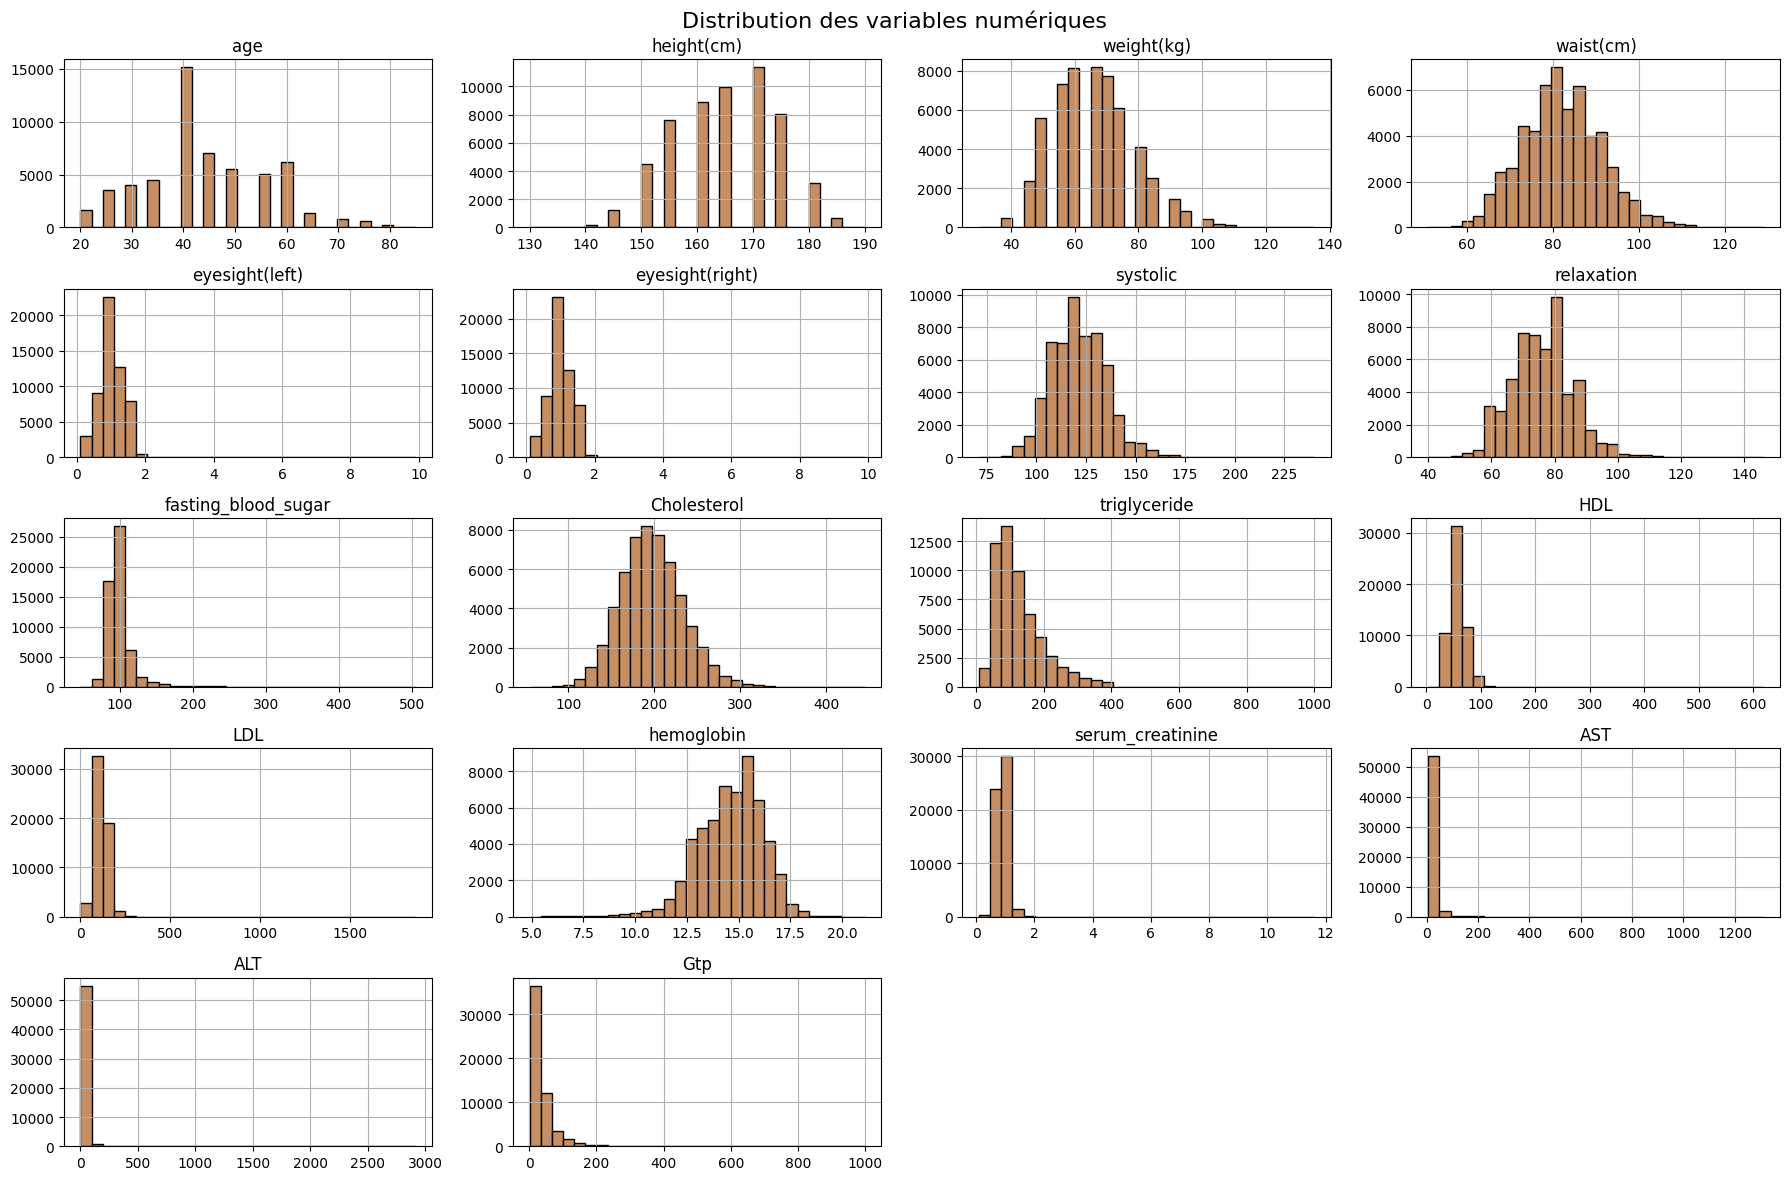

In [103]:
df[numerical_cols].describe().T

# Histogrammes
df[numerical_cols].hist(
    bins=30,
    figsize=(18, 12),
    grid=True,
    color=palette[0],
    edgecolor="black",
)

plt.suptitle("Distribution des variables numériques", fontsize=16)
plt.tight_layout()
plt.show()

### 5.2) Catégorielles

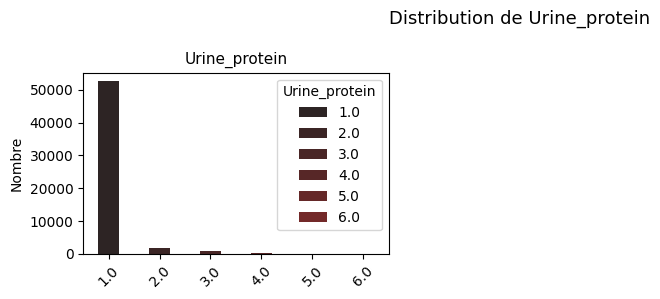

In [106]:

categorical_cols= types["categorical"]

n = len(categorical_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3 * n_rows))

for ax, col in zip(axes.flatten(), categorical_cols):
    sns.countplot(
        x=col,
        data=df,
        hue=col,
        palette='dark:#7F1D1D',
        dodge=False,
        width=0.4,  
        ax=ax
    )
    ax.set_title(f"{col}", fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("Nombre")
    ax.tick_params(axis='x', labelrotation=45)

for ax in axes.flatten()[n:]:
    ax.set_visible(False)

plt.suptitle(f"Distribution de {col}", fontsize=13)
plt.tight_layout()
plt.show()


### 5.3) Booléennes

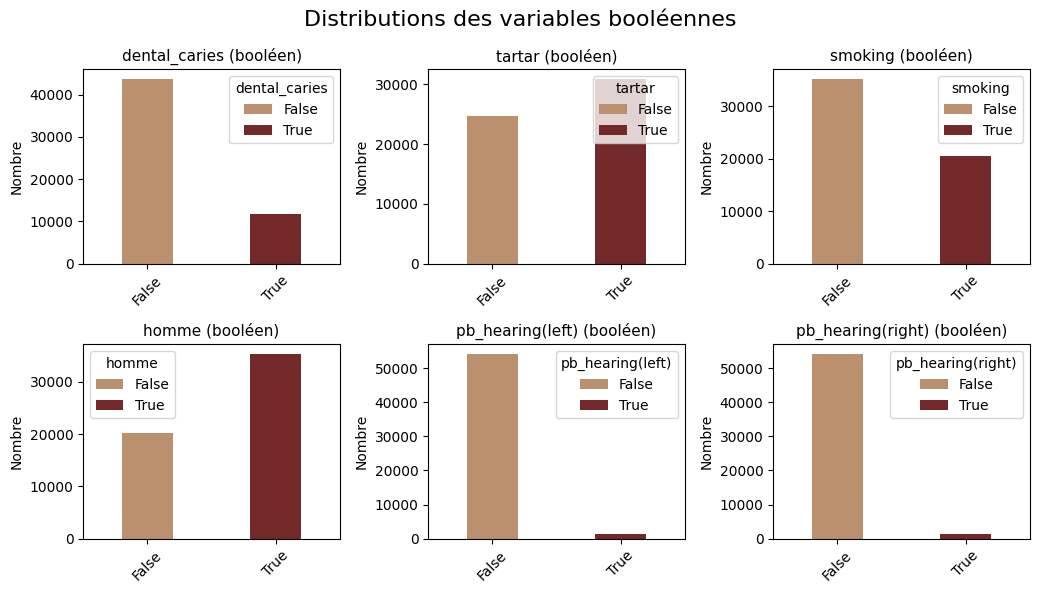

In [107]:
bool_cols = types["boolean"]

n = len(bool_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3 * n_rows))

for ax, col in zip(axes.flatten(), bool_cols):
    sns.countplot(
        x=col,
        data=df,
        hue=col,
        palette=palette,
        dodge=False,
        width=0.4,  
        ax=ax
    )
    ax.set_title(f"{col} (booléen)", fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("Nombre")
    ax.tick_params(axis='x', labelrotation=45)


for ax in axes.flatten()[n:]:
    ax.set_visible(False)

plt.suptitle("Distributions des variables booléennes", fontsize=16)
plt.tight_layout()
plt.show()

### variable binaire cible :

In [109]:
df['smoking'].value_counts()

smoking
False    35237
True     20455
Name: count, dtype: int64

### 5.4) Variables numériques vs smoking

**Objectif :** 

comparer les distributions des variables numériques selon la classe 

**Numérique vs cible**

In [112]:
df.groupby("smoking")[types["numerical"]].mean().T


smoking,False,True
age,45.677981,41.607431
height(cm),161.870477,169.436324
weight(kg),62.907455,70.959668
waist(cm),80.447669,84.800518
eyesight(left),0.989920,1.051733
eyesight(right),0.984110,1.047636
systolic,120.732440,122.806502
relaxation,75.206090,77.380787
fasting_blood_sugar,97.723501,102.049328
Cholesterol,197.690921,195.541384


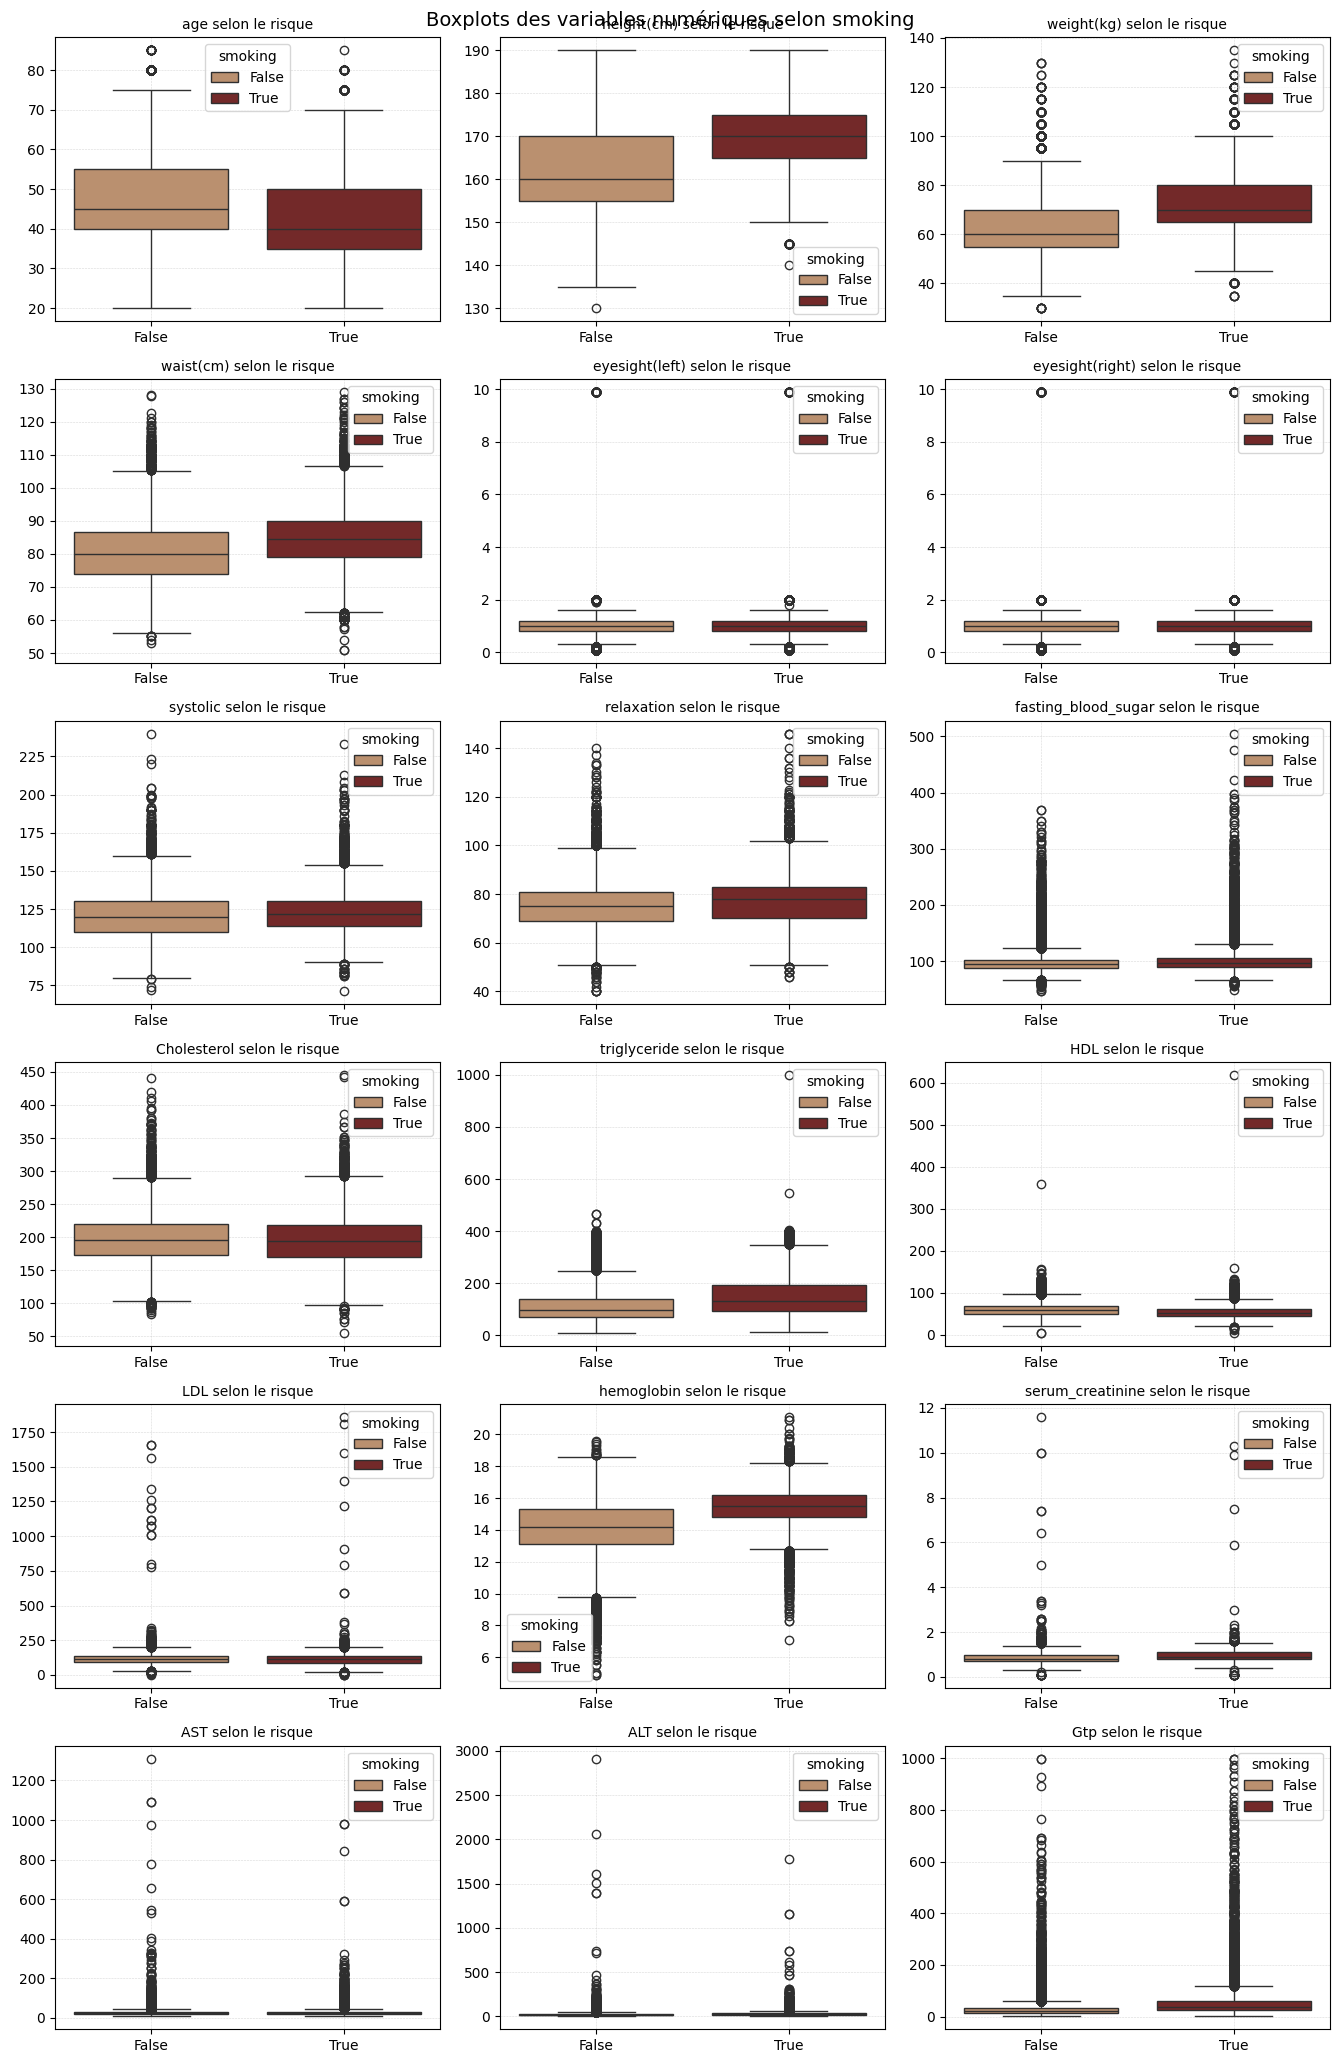

In [111]:
numerical_cols = [
    col for col in types["numerical"]
]

n = len(numerical_cols)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.5 * n_rows))

for ax, col in zip(axes.flatten(), numerical_cols):
    sns.boxplot(
        x="smoking",
        y=col,
        data=df,
        hue="smoking",
        palette=palette,
        dodge=False,
        ax=ax
    )
    ax.set_title(f"{col} selon le risque", fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.5)
    
for ax in axes.flatten()[n:]:
    ax.set_visible(False)

plt.suptitle("Boxplots des variables numériques selon smoking", fontsize=14)
plt.tight_layout()
plt.show()


### 5.5)  Variables catégorielles / booléennes vs smoking
Objectif : voir si certaines modalités sont plus fréquentes dans le risque

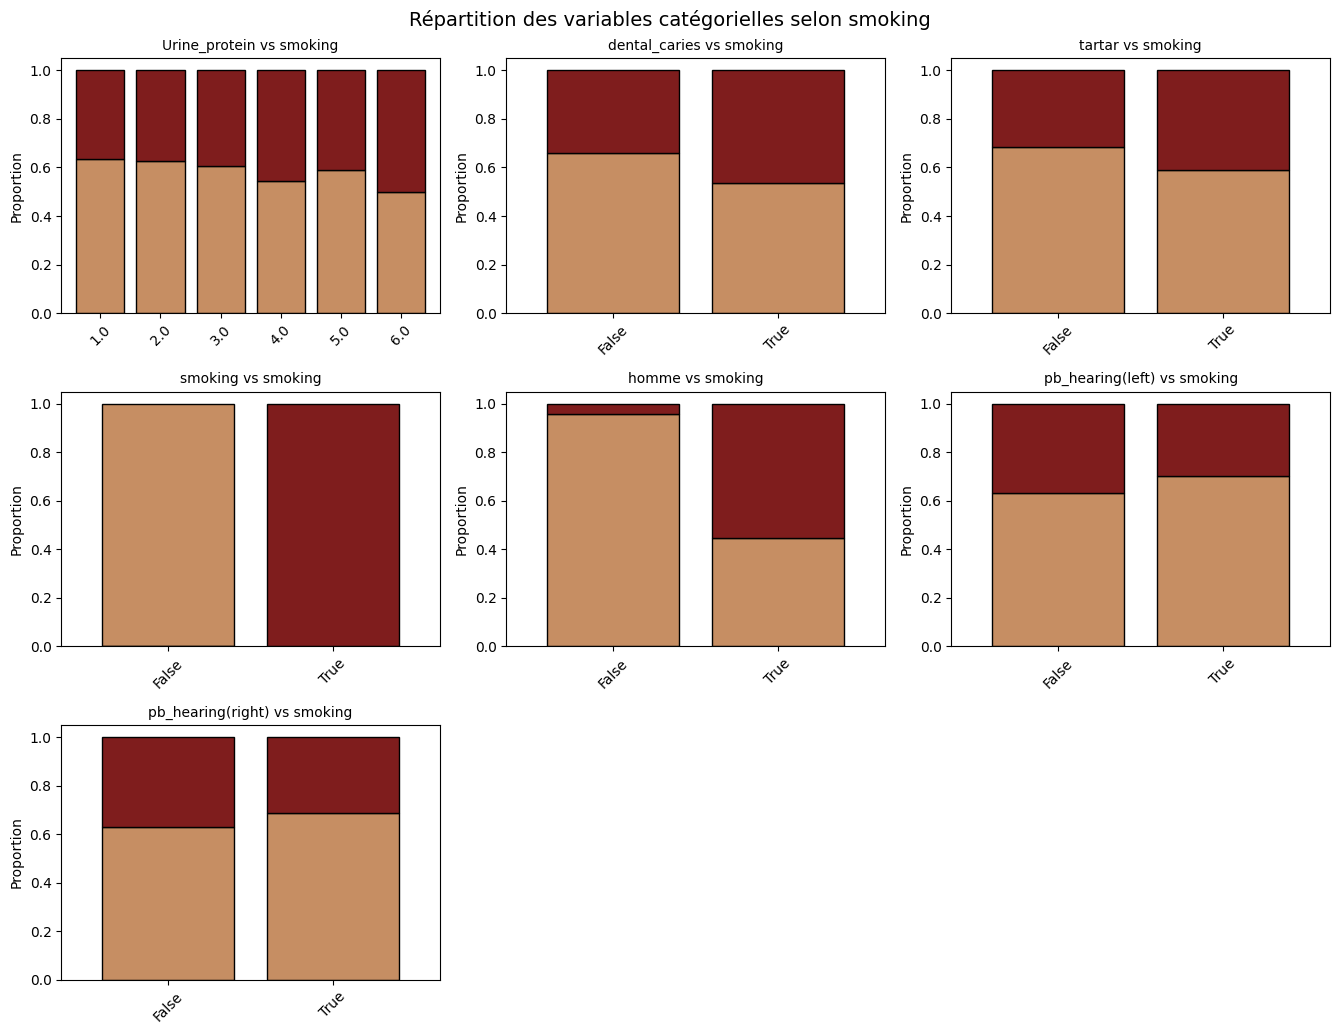

In [113]:
all_cats = types["categorical"] + types["boolean"]

n = len(all_cats)
n_cols = 3
n_rows = (n + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.5 * n_rows))

for ax, col in zip(axes.flatten(), all_cats):
    ct = pd.crosstab(df[col], df["smoking"], normalize='index')
    ct.plot(
        kind='bar',
        stacked=True,
        color=[palette[0], palette[1]],  # ex : ["#C68E63", "#7F1D1D"]
        edgecolor="black",
        ax=ax,
        width=0.8,
        legend=False
    )
    ax.set_title(f"{col} vs smoking", fontsize=10)
    ax.set_ylabel("Proportion")
    ax.set_xlabel("")
    ax.tick_params(axis='x', labelrotation=45)

for ax in axes.flatten()[n:]:
    ax.set_visible(False)

plt.suptitle("Répartition des variables catégorielles selon smoking", fontsize=14)
plt.tight_layout()
plt.show()

### 5.6) Corrélations 

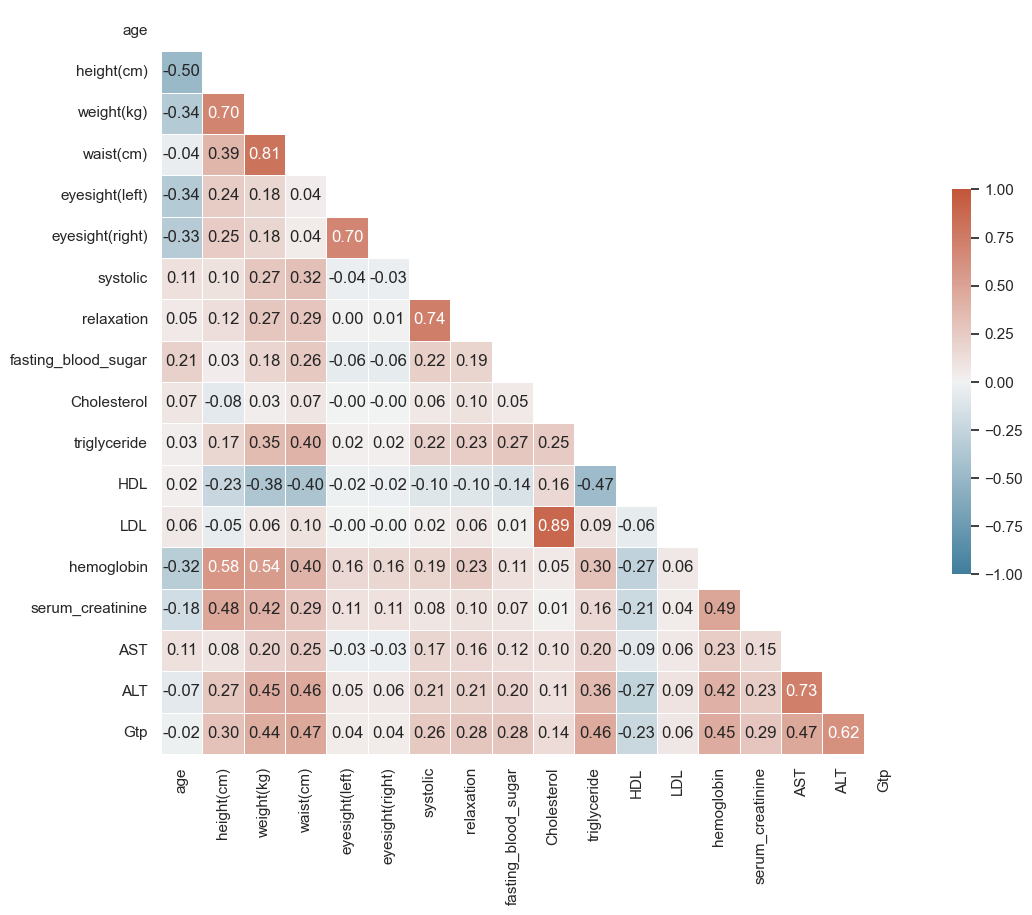

In [122]:
#  matrice de corrélation
sns.set(style="white")
corr = df[types["numerical"]].corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            vmin=-1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True,
            annot_kws={"size": 12},
            fmt='.2f'
            )
plt.show()


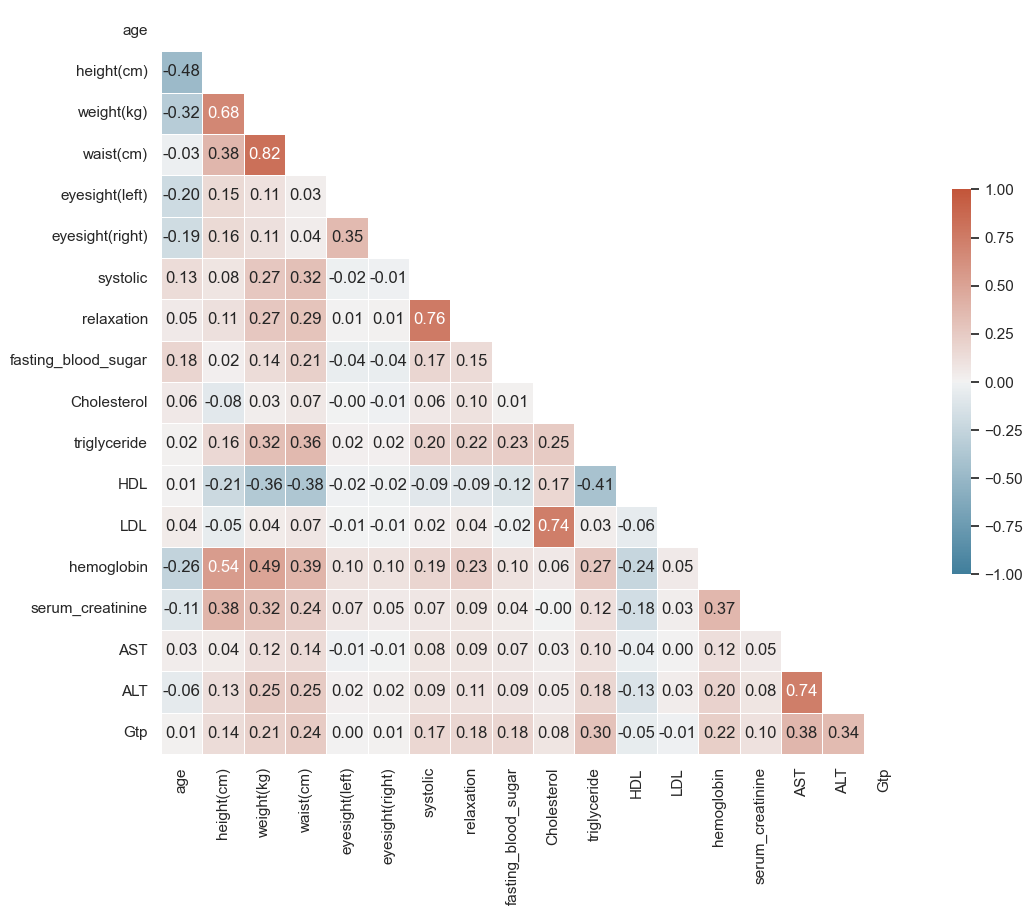

In [123]:
#  matrice de corrélation
sns.set(style="white")
corr = df[types["numerical"]].corr(method="pearson")
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            vmin=-1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True,
            annot_kws={"size": 12},
            fmt='.2f'
            )
plt.show()


### Corrélations numériques avec riskBinary

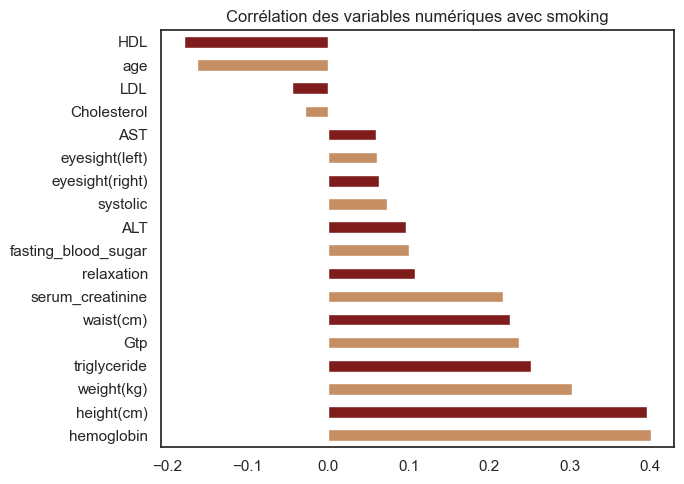

hemoglobin             0.400678
height(cm)             0.396675
weight(kg)             0.302780
triglyceride           0.251799
Gtp                    0.236619
waist(cm)              0.226259
serum_creatinine       0.216812
HDL                    0.178470
age                    0.162557
relaxation             0.108309
fasting_blood_sugar    0.100279
ALT                    0.097338
systolic               0.073109
eyesight(right)        0.063017
eyesight(left)         0.061204
AST                    0.059253
LDL                    0.045220
Cholesterol            0.028548
dtype: float64


In [ ]:
numerical_for_corr = [
    col for col in types["numerical"]
]

# Corrélation avec smoking
correlations = df[numerical_for_corr].corrwith(df["smoking"])
correlations.sort_values(ascending=False).plot(
    kind="barh",
    figsize=(7, 5),
    color=palette,
    title="Corrélation des variables numériques avec smoking"
)
plt.tight_layout()
plt.show()

print(correlations.abs().sort_values(ascending=False))


## 6 ) Détection des outliers 

In [128]:
Q1 = df[types["numerical"]].quantile(0.25)
Q3 = df[types["numerical"]].quantile(0.75)
IQR = Q3 - Q1

# Les valeurs inférieures à Q1 - 1.5*IQR ou supérieures à Q3 + 1.5*IQR sont des outliers
is_outlier = ((df[types["numerical"]] < (Q1 - 1.5 * IQR)) | 
              (df[types["numerical"]] > (Q3 + 1.5 * IQR)))

outliers_per_col_iqr = is_outlier.sum()

print("Outliers par variable (méthode IQR) :")
print(outliers_per_col_iqr)


Outliers par variable (méthode IQR) :
age                     295
height(cm)              249
weight(kg)              198
waist(cm)               496
eyesight(left)         1314
eyesight(right)        1357
systolic                685
relaxation              706
fasting_blood_sugar    3298
Cholesterol             605
triglyceride           2256
HDL                    1011
LDL                     634
hemoglobin              669
serum_creatinine       3147
AST                    3699
ALT                    3710
Gtp                    5019
dtype: int64


Cela montre que les enzymes hépatiques, la créatinine, la glycémie, les lipides, ainsi que l’acuité visuelle sont les plus touchées par des valeurs extrêmes

In [133]:
path = Path("..") / "data" / "df_clean.csv"
# Enregistrement du DataFrame nettoyé au format CSV
df.to_csv(path, index=False)